# Ultimate Inc. User Engagement Data Analysis

## Import Packages

In [1]:
from glob import glob
import pandas as pd
import numpy as np
from sklearn import preprocessing

try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
palette = sns.diverging_palette(220, 20, sep = 20, n = 150)
sns.set_palette(palette)

## Load Data

In [2]:
# Check csv files
data_dir = 'Data/*'
! ls {data_dir}

Data/logins.json                  Data/ultimate_data_challenge.json


## Part 1 - Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. 

Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.

Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [3]:
df_login = pd.read_json('Data/logins.json')
print(df_login.head(10))
print(df_login.info())

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
5 1970-01-01 20:21:41
6 1970-01-01 20:12:16
7 1970-01-01 20:35:47
8 1970-01-01 20:35:38
9 1970-01-01 20:47:52
<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB
None


In [4]:
df_login = df_login.sort_values(by = 'login_time')
df_login = df_login.set_index('login_time')
df_login['cnt'] = 1

print(df_login.head(10))

                     cnt
login_time              
1970-01-01 20:12:16    1
1970-01-01 20:13:18    1
1970-01-01 20:16:10    1
1970-01-01 20:16:36    1
1970-01-01 20:16:37    1
1970-01-01 20:21:41    1
1970-01-01 20:26:05    1
1970-01-01 20:26:21    1
1970-01-01 20:31:03    1
1970-01-01 20:34:46    1


In [5]:
def resample(data, rule):
    data_resample = data.resample(rule).count()
    data_resample.plot(figsize = (20, 8), title = 'Number of Login Counts based on ' + rule + ' Time Intervals')
    print(data_resample.head())
    print(data_resample.tail())

                     cnt
login_time              
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
                     cnt
login_time              
1970-04-13 17:45:00    5
1970-04-13 18:00:00    5
1970-04-13 18:15:00    2
1970-04-13 18:30:00    7
1970-04-13 18:45:00    6


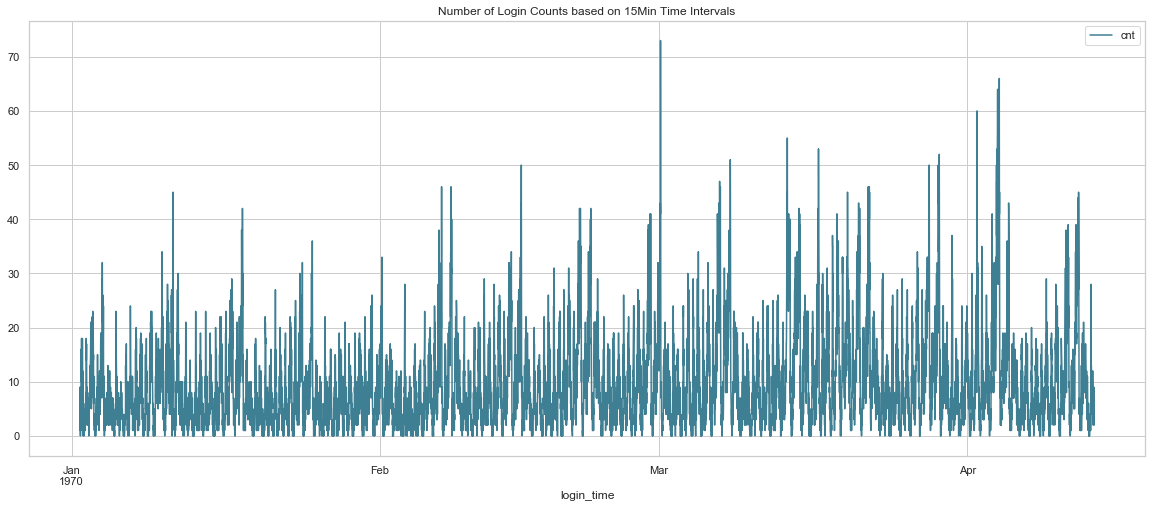

In [6]:
resample(df_login, '15Min')

From the above plot, it seems that there're some patterns of login counts but it's hard to directly tell from the above plot which is counted based on 15 min time intermals.

As time can be classify into min, hr, day, weekday, weekend and month. Let's try to aggregate by differnt time intervals.

                     cnt
login_time              
1970-01-01 20:00:00   24
1970-01-01 21:00:00    9
1970-01-01 22:00:00   21
1970-01-01 23:00:00   58
1970-01-02 00:00:00   53
                     cnt
login_time              
1970-04-13 14:00:00   32
1970-04-13 15:00:00   19
1970-04-13 16:00:00   22
1970-04-13 17:00:00   22
1970-04-13 18:00:00   20


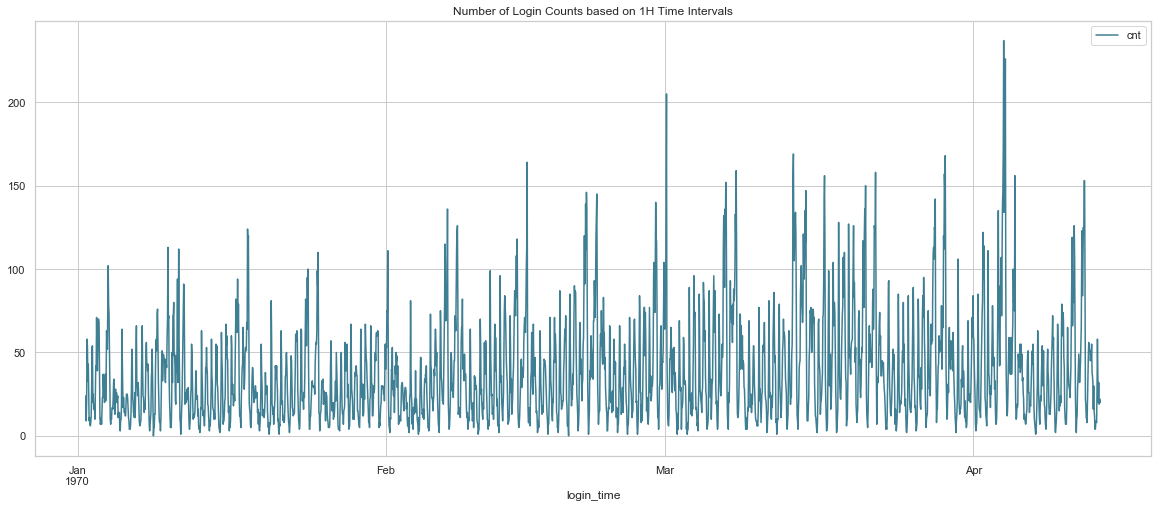

In [7]:
resample(df_login, '1H')

            cnt
login_time     
1970-01-01  112
1970-01-02  681
1970-01-03  793
1970-01-04  788
1970-01-05  459
             cnt
login_time      
1970-04-09   818
1970-04-10  1009
1970-04-11  1352
1970-04-12  1409
1970-04-13   395


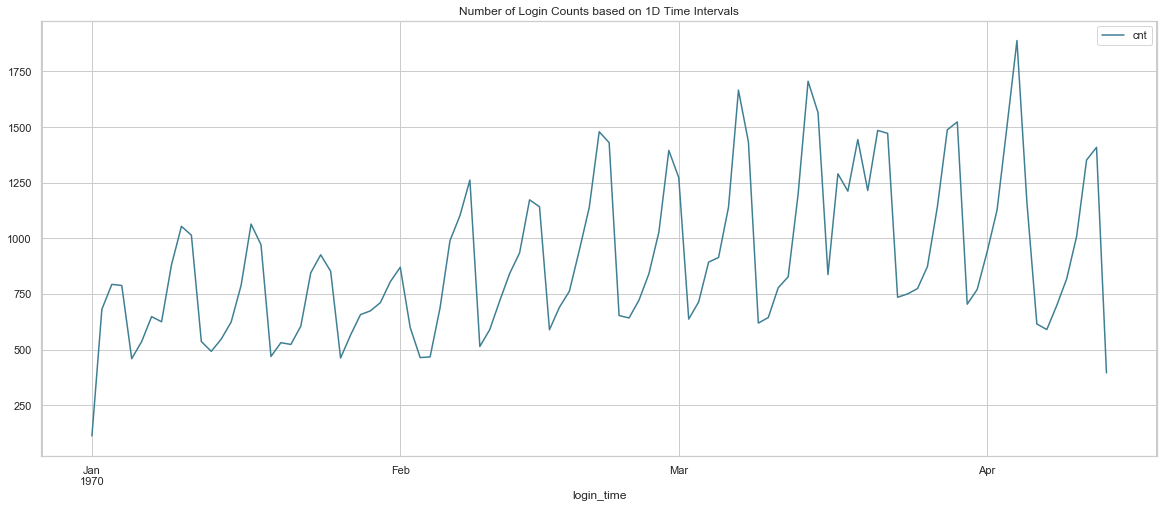

In [8]:
# resample based on 1day time intervals.
resample(df_login, '1D')

By looking at login count per days. Apparently there're some patteerns which are very similar to week period since there are always 4 to 5 peaks in a month. Let's take a closer look:

             cnt
login_time      
1970-02-01   870
1970-02-02   599
1970-02-03   464
1970-02-04   467
1970-02-05   688
1970-02-06   990
1970-02-07  1102
1970-02-08  1262
1970-02-09   514
1970-02-10   590
1970-02-11   719
1970-02-12   842
1970-02-13   935
1970-02-14  1173
1970-02-15  1142
1970-02-16   589
1970-02-17   690
1970-02-18   762
1970-02-19   946
1970-02-20  1139
1970-02-21  1479
1970-02-22  1430
1970-02-23   653
1970-02-24   642
1970-02-25   722
1970-02-26   841
1970-02-27  1028
1970-02-28  1395
1970-03-01  1273


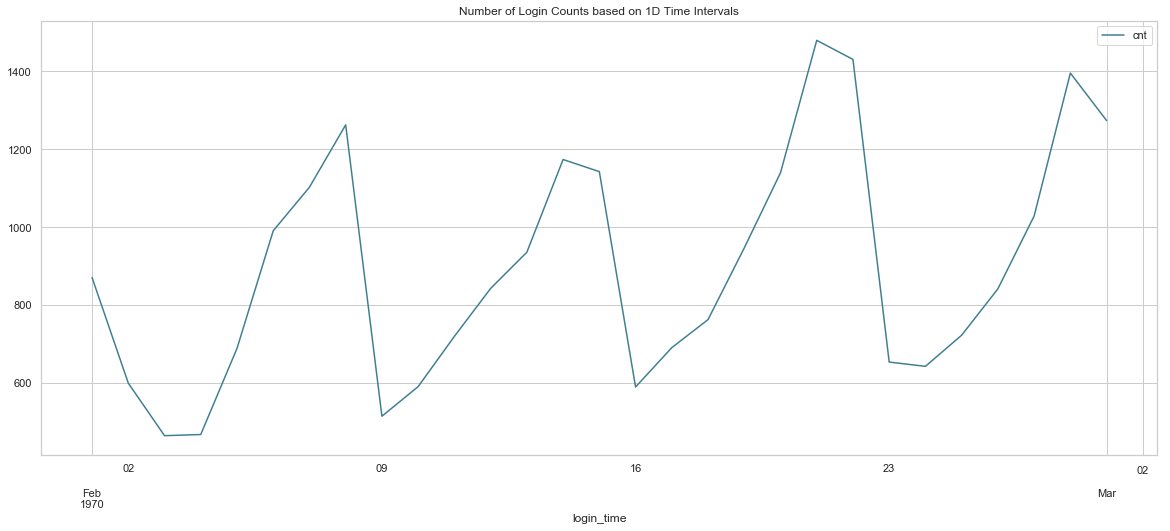

In [9]:
df_login_temp = df_login['1970-02-01': '1970-03-01'].resample('1D').count()
df_login_temp.plot(figsize = (20, 8), title = 'Number of Login Counts based on ' + '1D' + ' Time Intervals')
print(df_login_temp.head(50))

Yes there are apparent patterns within a 7 day period.

Let's print out the weekday to check:

In [10]:
# Get weekday. The day of the week with Monday=0, Sunday=6
df_login_temp = df_login['1970-02-01': '1970-03-01'].resample('1D').count()
df_login_temp['weekday'] = df_login_temp.index.weekday
print(df_login_temp.head(50))

             cnt  weekday
login_time               
1970-02-01   870        6
1970-02-02   599        0
1970-02-03   464        1
1970-02-04   467        2
1970-02-05   688        3
1970-02-06   990        4
1970-02-07  1102        5
1970-02-08  1262        6
1970-02-09   514        0
1970-02-10   590        1
1970-02-11   719        2
1970-02-12   842        3
1970-02-13   935        4
1970-02-14  1173        5
1970-02-15  1142        6
1970-02-16   589        0
1970-02-17   690        1
1970-02-18   762        2
1970-02-19   946        3
1970-02-20  1139        4
1970-02-21  1479        5
1970-02-22  1430        6
1970-02-23   653        0
1970-02-24   642        1
1970-02-25   722        2
1970-02-26   841        3
1970-02-27  1028        4
1970-02-28  1395        5
1970-03-01  1273        6


Yes the login count appears to be higher on weekends and lower on weekdays, repeatedly.

After identifying the pattern of week, let's see what's the daily pattern of weekdays vs. weekends.

In [11]:
# Get data of one week, resample based on 1 Hour time intervals and plot for each weekday.
def get_sub_plot(width = 16, height = 5, label_font_size = 14, tick_font_size = 13):
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)
    ax.tick_params(labelsize = tick_font_size)
    ax.set_xlabel(ax.get_xlabel(), fontsize = label_font_size)
    ax.set_ylabel(ax.get_ylabel(), fontsize = label_font_size)
    return ax

def plot_cnt_per_hour(data):
    dates = list(set(data.index.date))

    ax = get_sub_plot()

    for date in dates:
        data_per_day = data[str(date): str(date)].resample('1H').count()
        sns.lineplot(data = data_per_day, x = data_per_day.index.hour, y = 'cnt', ax = ax)

    plt.show()

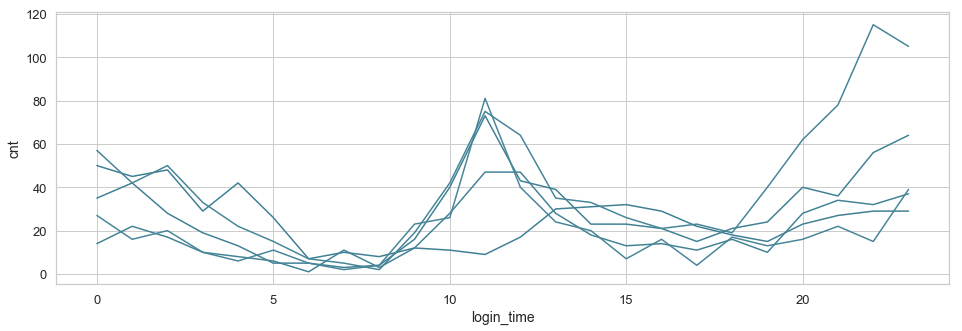

In [12]:
df_login_mon_to_thur = df_login['1970-02-02': '1970-02-06']
plot_cnt_per_hour(df_login_mon_to_thur)

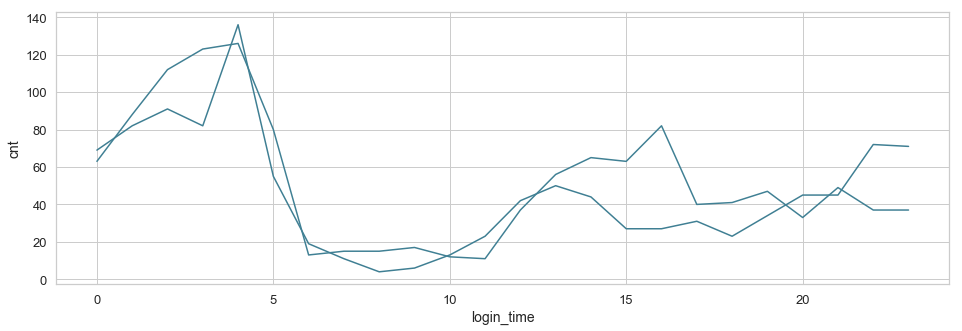

In [13]:
df_login_mon_to_thur = df_login['1970-02-07': '1970-02-08']
plot_cnt_per_hour(df_login_mon_to_thur)

Interestingly the login count pattern is also pretty consistent.

On weekdays there's a peak at noon. On weekends there's a peak in the early morning.

Let's confirm by checking another week:

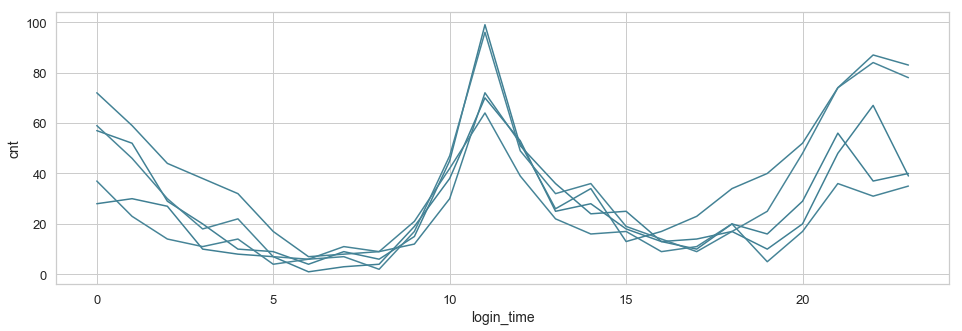

In [14]:
df_login_mon_to_thur = df_login['1970-02-09': '1970-02-13']
plot_cnt_per_hour(df_login_mon_to_thur)

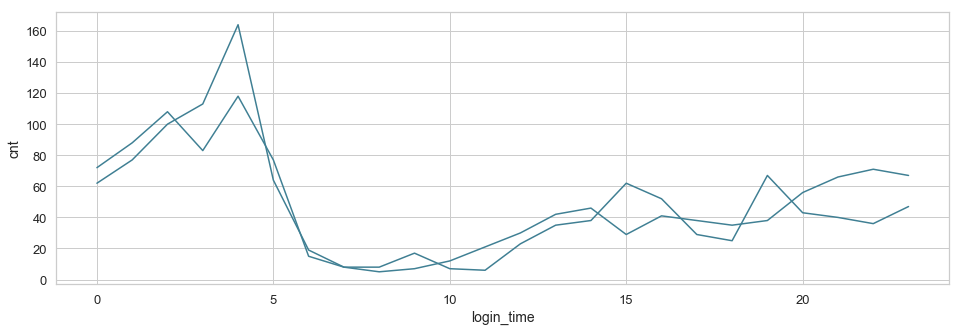

In [15]:
df_login_mon_to_thur = df_login['1970-02-14': '1970-02-15']
plot_cnt_per_hour(df_login_mon_to_thur)

Yes the following week still follows the same pattern.

> Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.

**The time of login history spans from 1970-01-01 to 1970-04-13. There are total 93142 logins.**

**When resampling based on 1day time intervals, we can see apparent pattern with a 7-day period. To be more specific, the login count appears to be higher on weekends and lower on weekdays, repeatedly in a 7-day period.**

**When resmapling based on 1 Hr timg intervals on weekdays, apparently there is a peak of login count at noon, while on weekends, there is a peak in the early morning.**

## Part 2 - Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
  * how you will implement the experiment
  * what statistical test(s) you will conduct to verify the significance of the observation
  * how you would interpret the results and provide recommendations to the city operations team along with any caveats.

Let's first work on the metric:

> 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

** The key metric I would use is the product profitability.**

> 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
  * how you will implement the experiment
  * what statistical test(s) you will conduct to verify the significance of the observation
  * how you would interpret the results and provide recommendations to the city operations team along with any caveats.
  
The key measure of success in this experiment would be profit. The first two times a driver partner took advantage of the reimbursement policy would be to test it out, to decide for themselves through experience if the trip was made worth the cost and time because of a toll reimbursement.

Does consistent toll reimbursement encourage driver partners to expand their geographic range of service? Some driver partners may decide the reimbursement is not worth it, in which case, the overall indicator that the experiment was a general success would be found in profit increase. If the profit does not change, then Ultimate would be able to see that toll reimbursements are not enough to encourage driver partners to cross cities.

I would implement the experiment as followed,

**assuming we have the data of the profit before and after starting to reimburse the toll cost to driver parters,**

**Null hypothesis: Reimbursing all toll costs to driver parters to encourage them to be available in both cities would NOT increase the total profit.**

** Alternate Hypothosis: Reimbursing all toll costs to driver parters to encourage them to be available in both cities would increase the total profit.**

** Test Statistic: Profit mean**

**If p-value is less than 0.05, we can reject the null hypothesis and prove that reimbursing all toll costs to drivers would increase the profit.**

## Part 3 - Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

## Data description
* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYY MM DD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday